<strong><b><font size="5">Time Series Analysis and Forecasting in Python</font></b></strong>

# Time Series
- A time series is a sequential set of data points, measured typically over successive times. 
- It is mathematically defined as a set of vectors x(t), t = 0,1,2,... where t represents the time elapsed. 
- The variable x(t) is treated as a random variable. 
- The measurements taken during an event in a time series are arranged in a proper chronological order. 
- A time series containing records of a single variable is termed as univariate, and more than one variable a multivariate. 

# Business use cases of time series forecasting
- __Sales forecast - retail products sales forecast__
- __Demand forecasting - used in pricing, inventory and workforce management__
- __Traffic forecast - transport and route optimization, road facility design__
- __Revenue forecast - budgeting, target setting__

# Importing Libraries for time series forecasting

In [286]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

from math import sqrt
import os,sys,re
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [287]:

! git clone https://github.com/AbhiRathore/datafiles.git


fatal: destination path 'datafiles' already exists and is not an empty directory.


In [288]:
os.listdir('datafiles')

['Time Series in Python.ipynb',
 'test_1eLl9Yf.csv',
 'aapl.csv',
 'international-airline-passengers.csv',
 'avocado.csv',
 'sample_submission_IIzFVsf.csv',
 'train_fwYjLYX.csv',
 '.git',
 'US Corn Futures Historical Data.csv']

# Importing data
- Dataset: International airline passengers
- Unit: Thousands

In [79]:
df = pd.read_csv('datafiles/international-airline-passengers.csv',header=None)

In [80]:
df.columns = ['year','passengers']

In [81]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [82]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    object
 1   passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [84]:
df.describe(include='O')

,year
count,144
unique,144
top,1951-02
freq,1


In [85]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [86]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [87]:
df.shape

(144, 2)

# Data Preprocessing and Visualization

__Converting to datetime format:__

In [88]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    datetime64[ns]
 1   passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


__Setting index as the datetime column for easier manipulations:__

In [90]:
y = df.set_index('year')

In [91]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [92]:
y

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [93]:
y.isnull().sum()

passengers    0
dtype: int64

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

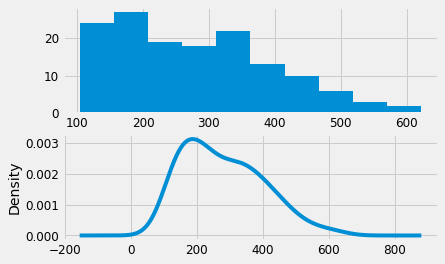

In [94]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Box and Whisker Plots:__
- Median values across years confirms an upwards trend
- Steady increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

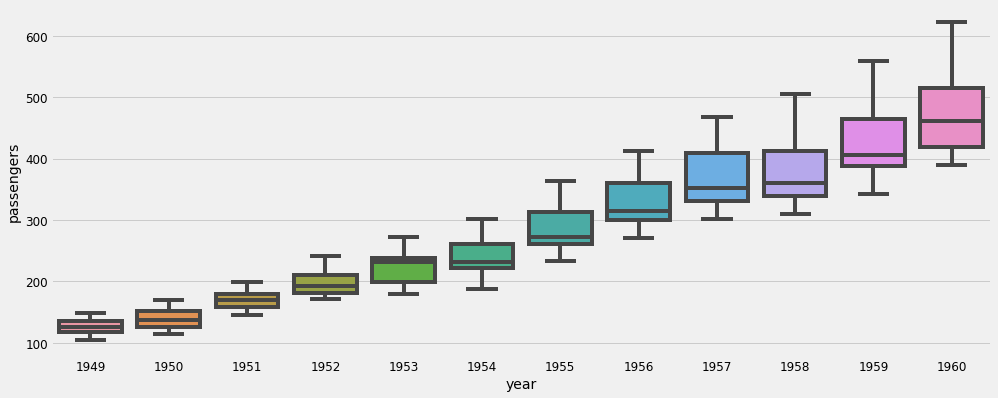

In [95]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

__Decomposing using statsmodel:__
- We can use statsmodels to perform a decomposition of this time series. 
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. 
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

In [96]:
pd.plotting.register_matplotlib_converters()


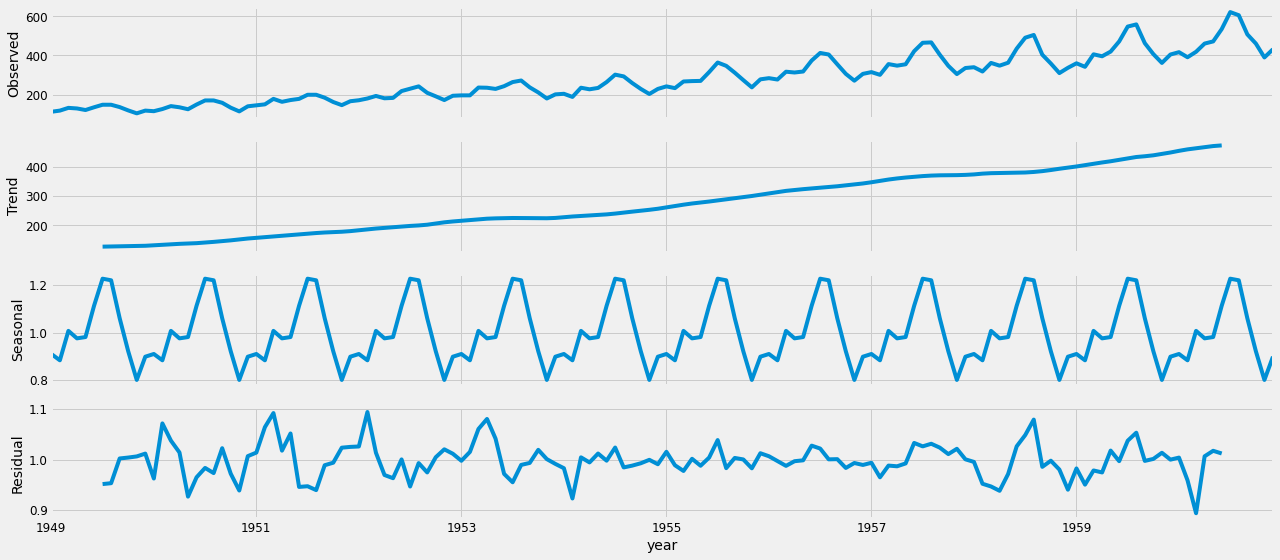

In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

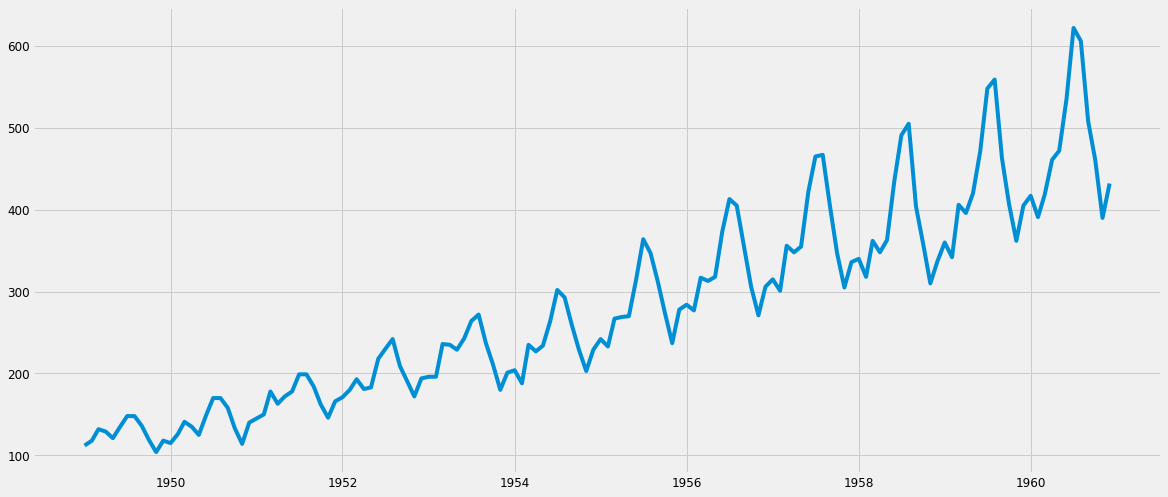

In [98]:
plt.plot(y)

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

### ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

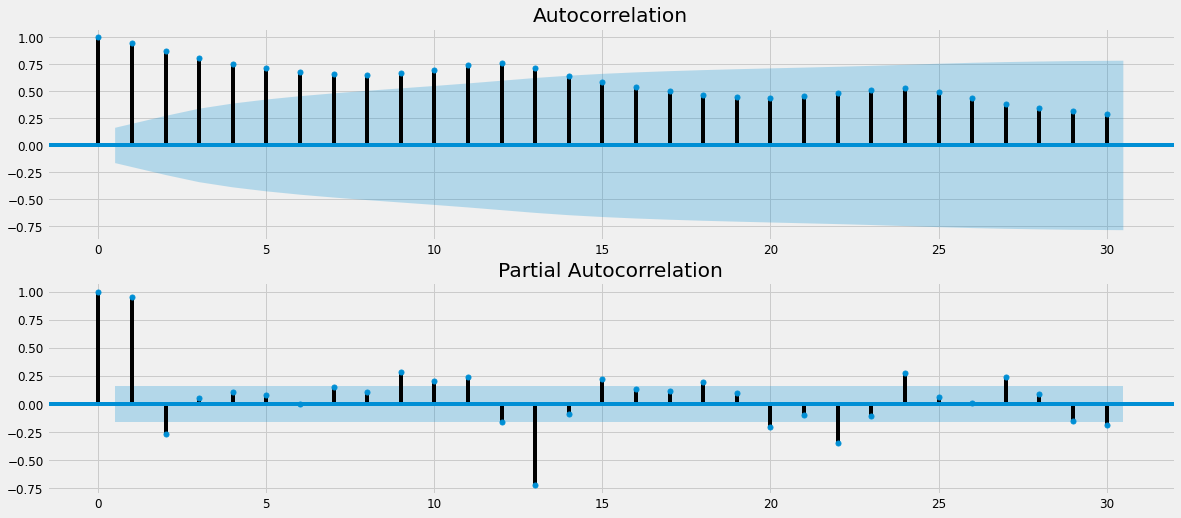

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

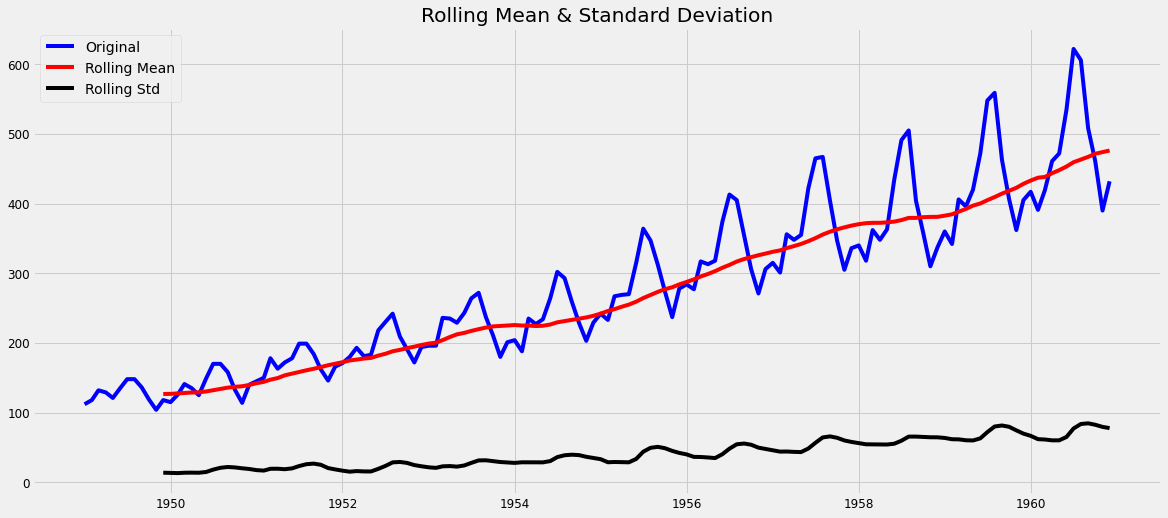

In [100]:
#Determing rolling statistics
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


### Augmented Dickey-Fuller Test
- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [101]:
from statsmodels.tsa.stattools import adfuller

In [102]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [103]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

1. __Trend__ – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. __Seasonality__ – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Transformations
- We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

#### Log Scale Transformation

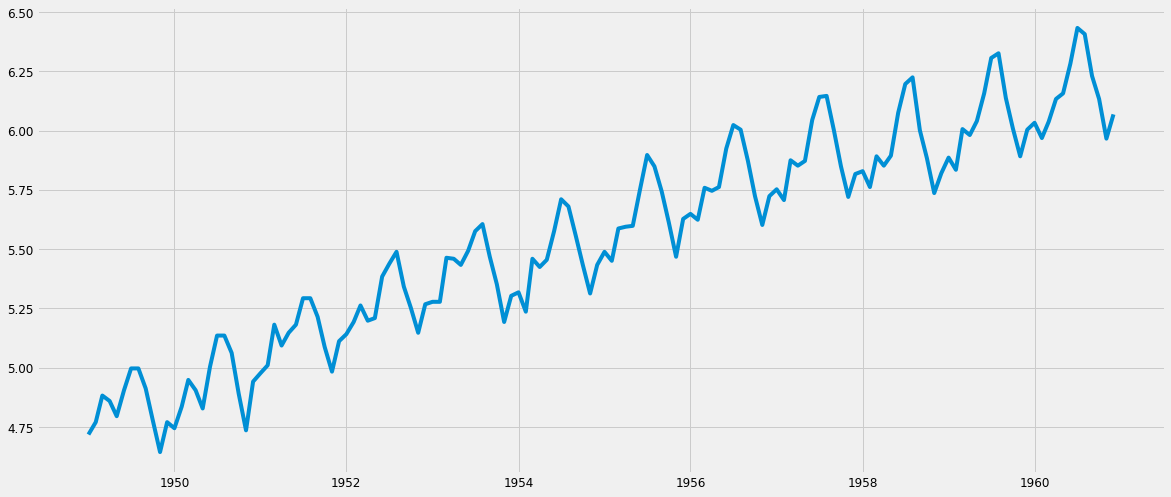

In [104]:
ts_log = np.log(y)
plt.plot(ts_log)

#### Other possible transformations:
- Exponential tranformation
- Box Cox transformation
- Square root transformation

### Techniques to remove Trend - Smoothing
- Smoothing is taking rolling averages over windows of time

#### Moving Average
- We take average of ‘k’ consecutive values depending on the frequency of time series. 
- Here we can take the average over the past 1 year, i.e. last 12 values. 
- A drawback in this particular approach is that the time-period has to be strictly defined. 

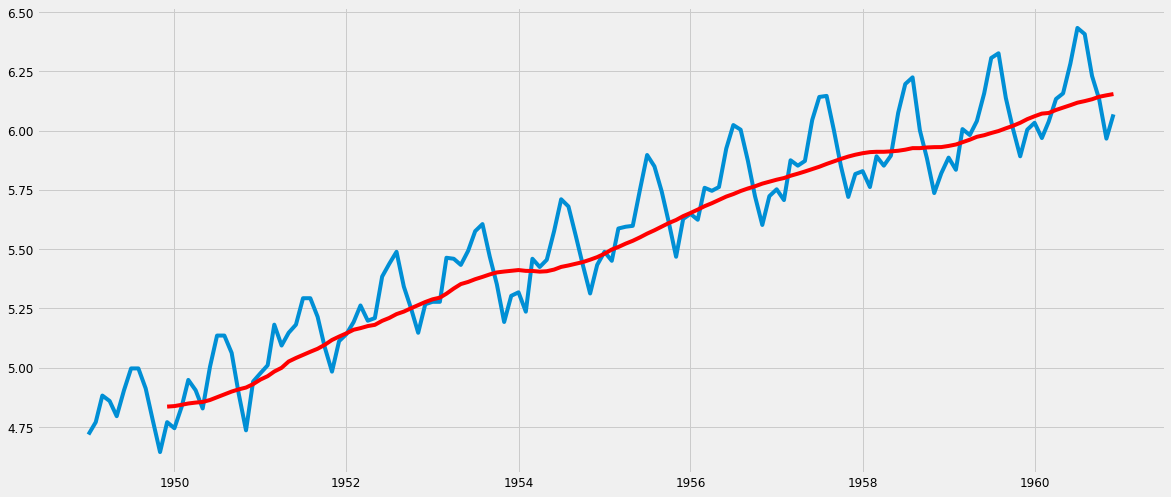

In [105]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [106]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

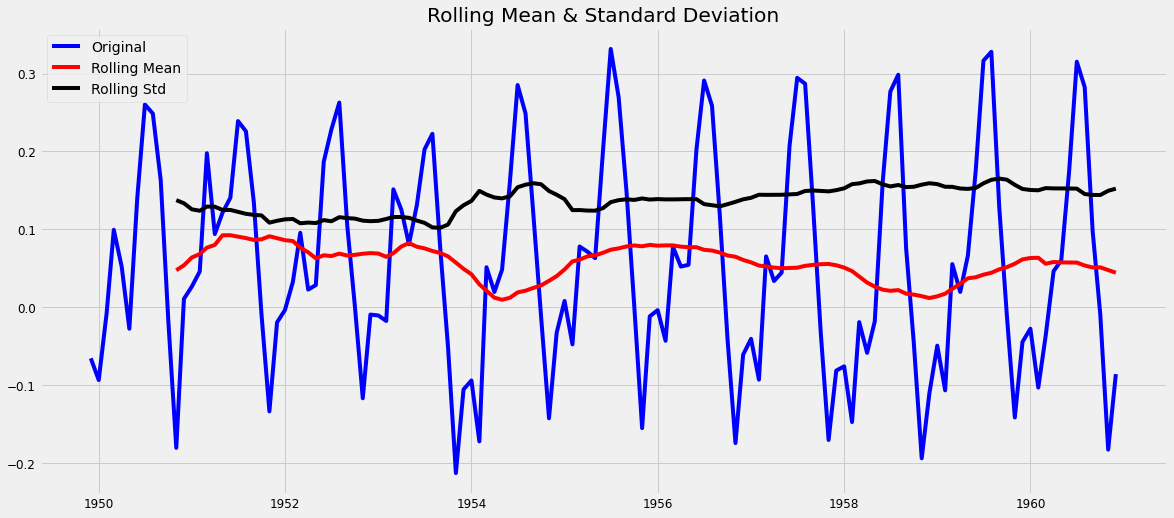

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [107]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Exponentially weighted moving average:
- To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
- We take a ‘weighted moving average’ where more recent values are given a higher weight. 
- There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

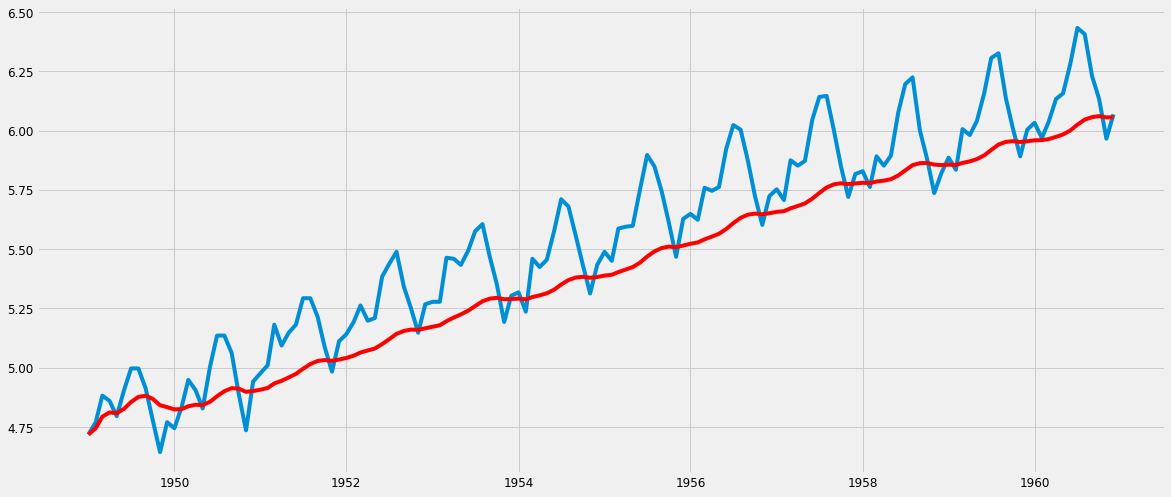

In [108]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

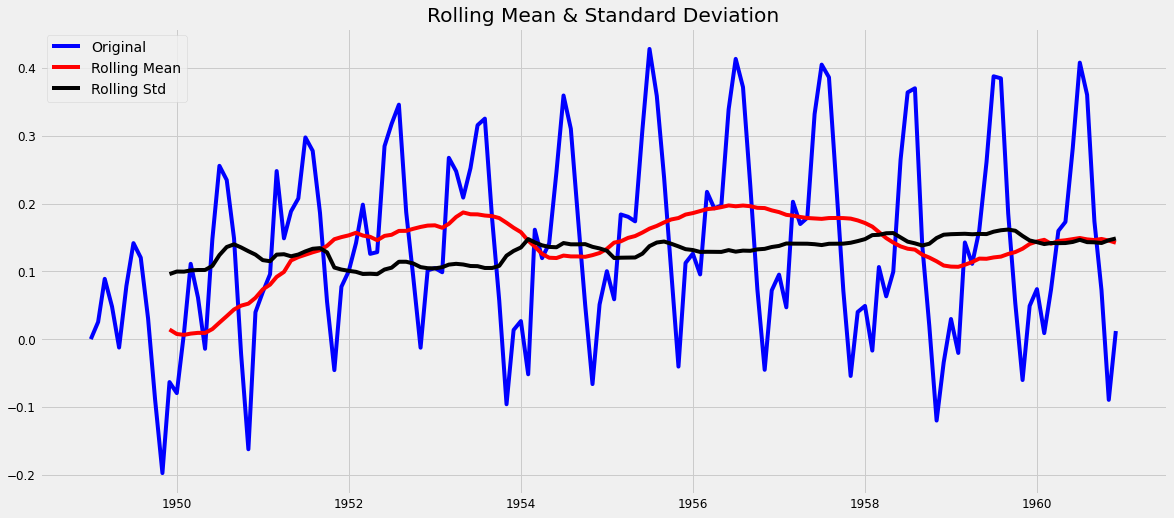

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [109]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Further Techniques to remove Seasonality and Trend
- The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. 

#### Differencing
- In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
- First order differencing in Pandas

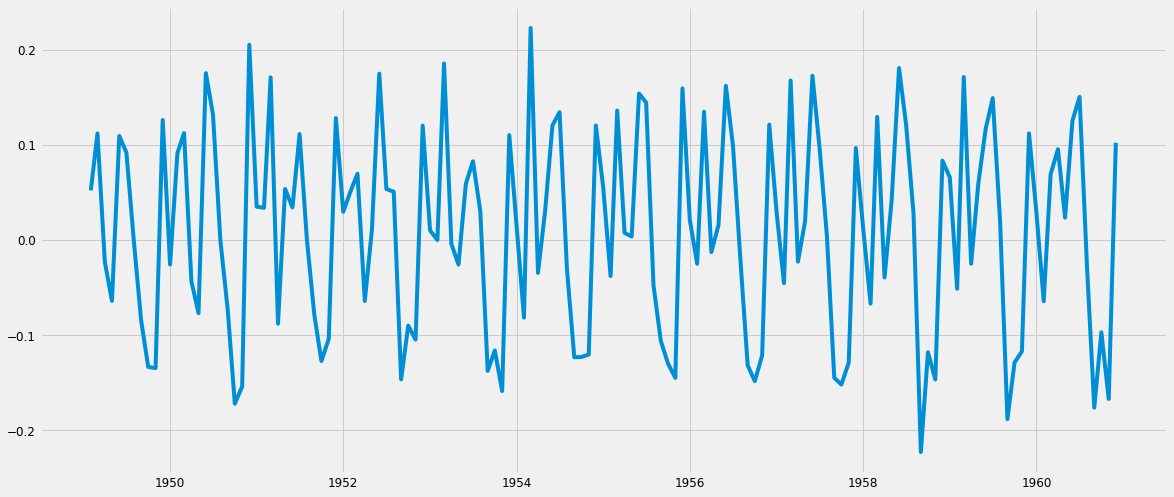

In [110]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

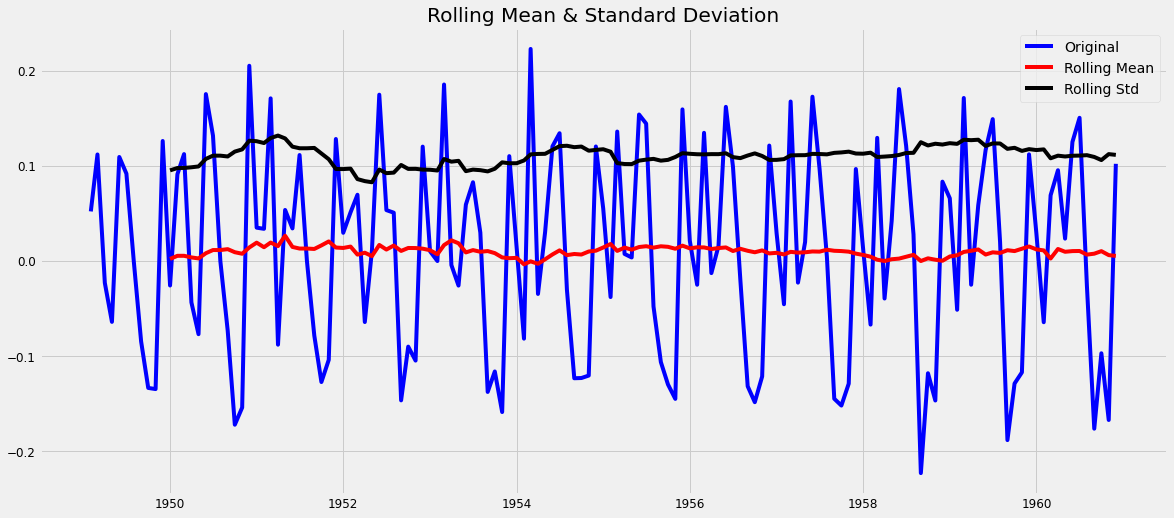

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [111]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Decomposition
- In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

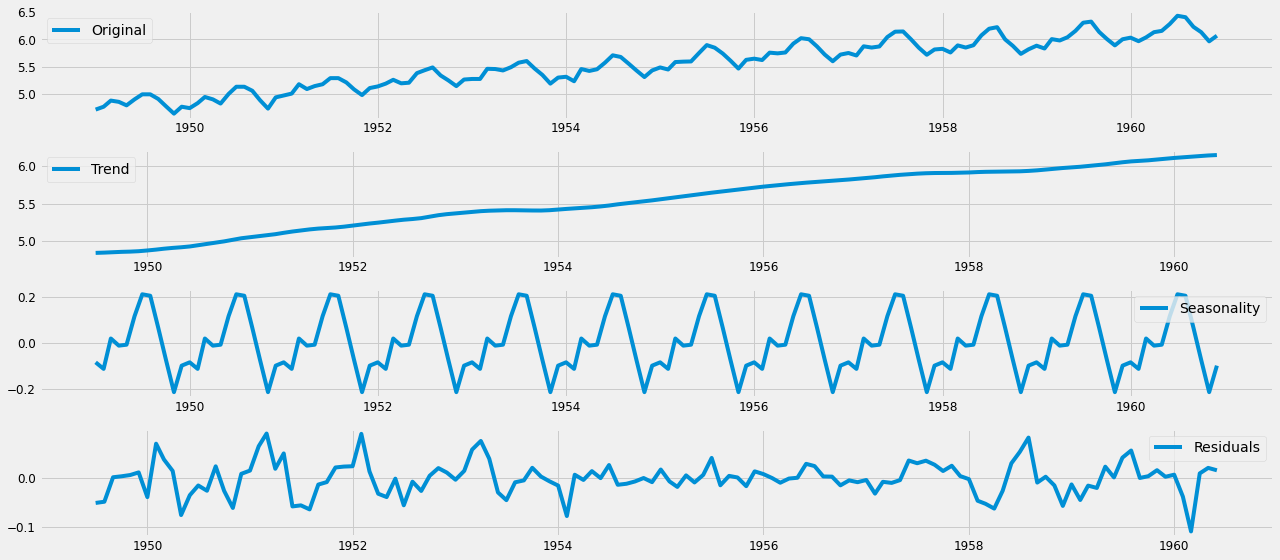

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

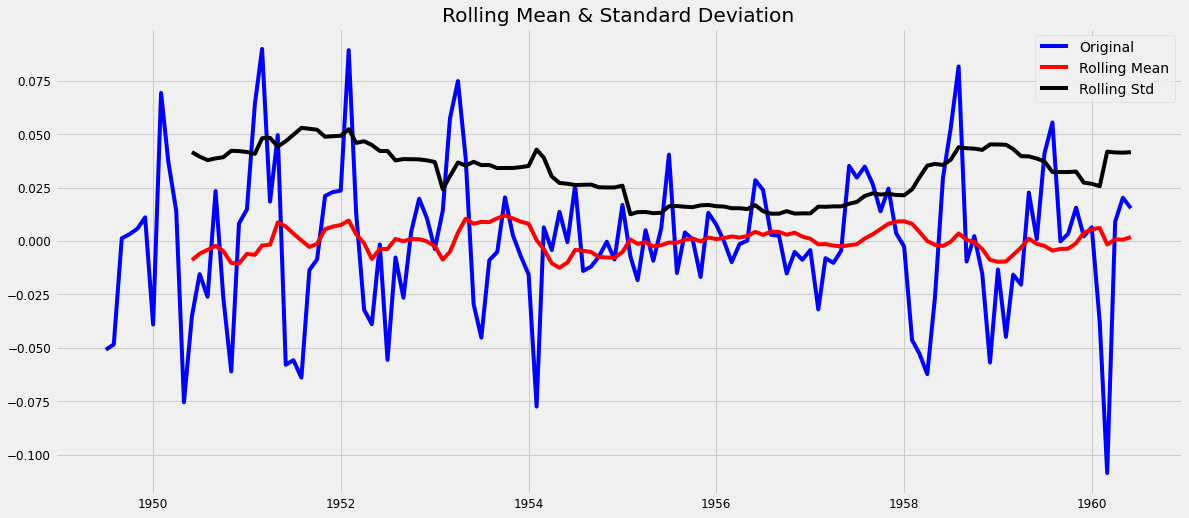

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [113]:
ts_log_decompose = residual.passengers
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Time Series forecasting
[Statsmodel example notebooks](https://github.com/statsmodels/statsmodels/tree/master/examples/notebooks)

## Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [114]:
from statsmodels.tsa.ar_model import AR
from random import random

In [115]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

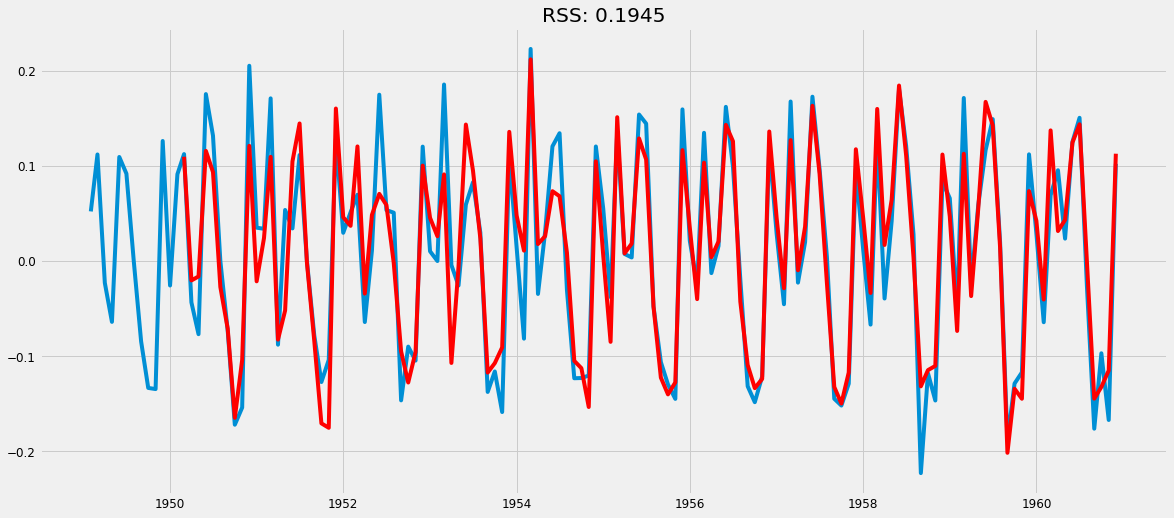

In [116]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reversing the transformations

__Fitted or predicted values:__

In [117]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


__Cumulative Sum to reverse differencing:__

In [118]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [119]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

__Taking Exponent to reverse Log Transform:__

In [120]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.5144')

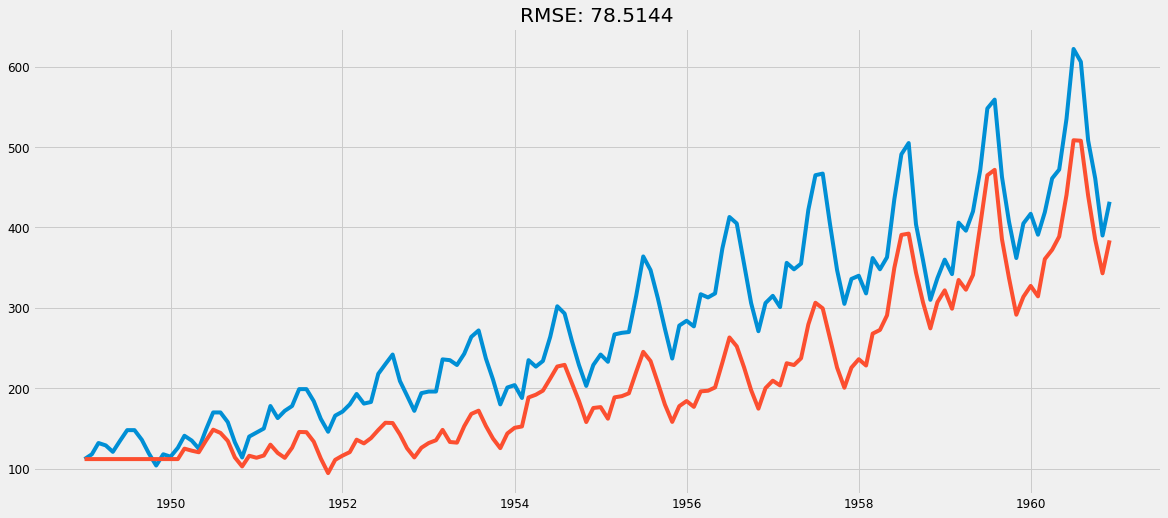

In [121]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

### Forecast quality scoring metrics
- __R squared__
- __Mean Absolute Error__
- __Median Absolute Error__
- __Mean Squared Error__
- __Mean Squared Logarithmic Error__
- __Mean Absolute Percentage Error__

In [122]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [123]:
r2_score(y.passengers, predictions_ARIMA)

0.5686734896130741

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [124]:
mean_absolute_error(y.passengers, predictions_ARIMA)

69.42862838872749

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [125]:
median_absolute_error(y.passengers, predictions_ARIMA)

69.36695435384767

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error


In [126]:
mean_squared_error(y.passengers, predictions_ARIMA)

6164.506983577633

__Mean Squared Logarithmic Error__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [127]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.09945599448249766

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), 
- not implemented in sklearn

In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [129]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.472405429862356

__Function to evaluate forecast using above metrics:__

In [130]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [131]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


- RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

- From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

- On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

## Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [132]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [133]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Sun, 29 Nov 2020   AIC                           -237.507
Time:                        05:18:13   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.377      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.005       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.5245')

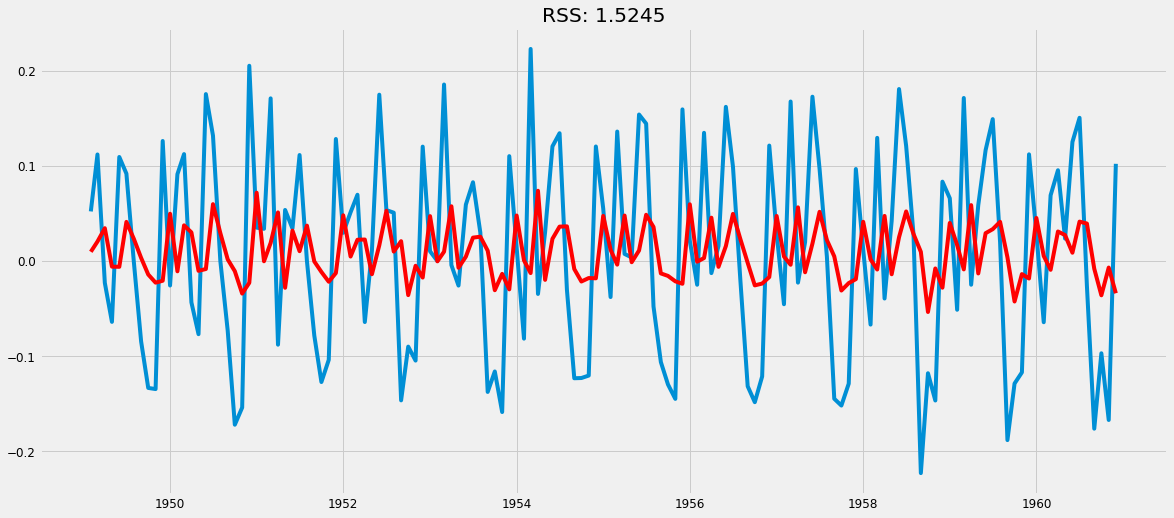

In [134]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Moving Average (ARMA)

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [135]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

In [136]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(2, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Sun, 29 Nov 2020   AIC                           -270.151
Time:                        05:18:17   BIC                           -255.337
Sample:                    02-01-1949   HQIC                          -264.131
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0101      0.000     23.507      0.000       0.009       0.011
ar.L1.passengers     0.9983      0.076     13.163      0.000       0.850       1.147
ar.L2.passengers    -0.4134      0.077     -5.384      0.000      -0.564      -0.263
ma.L1.passengers    -0.9999      0.028    -35.278      0.000      -1.055      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9804j            1.5552           -0.1086
AR.2            1.2073           +0.9804j            1.5552            0.1086
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.1753')

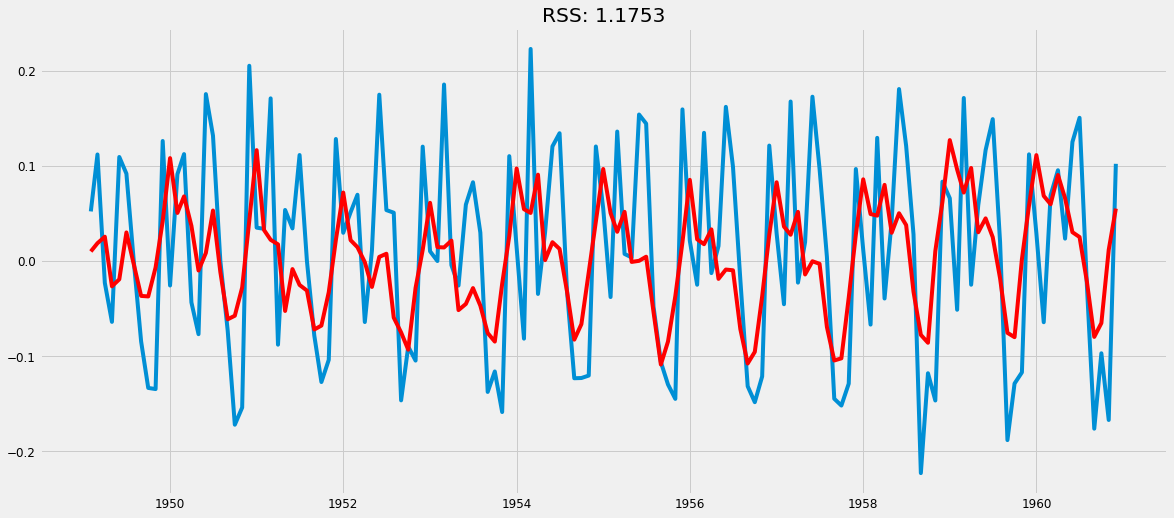

In [137]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Integrated Moving Average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [138]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

__ACF and PACF plots after differencing:__
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- AR(1) process -- has ACF tailing out and PACF cutting off at lag=1
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1
- MA(2) process -- has ACF cut off at lag=2

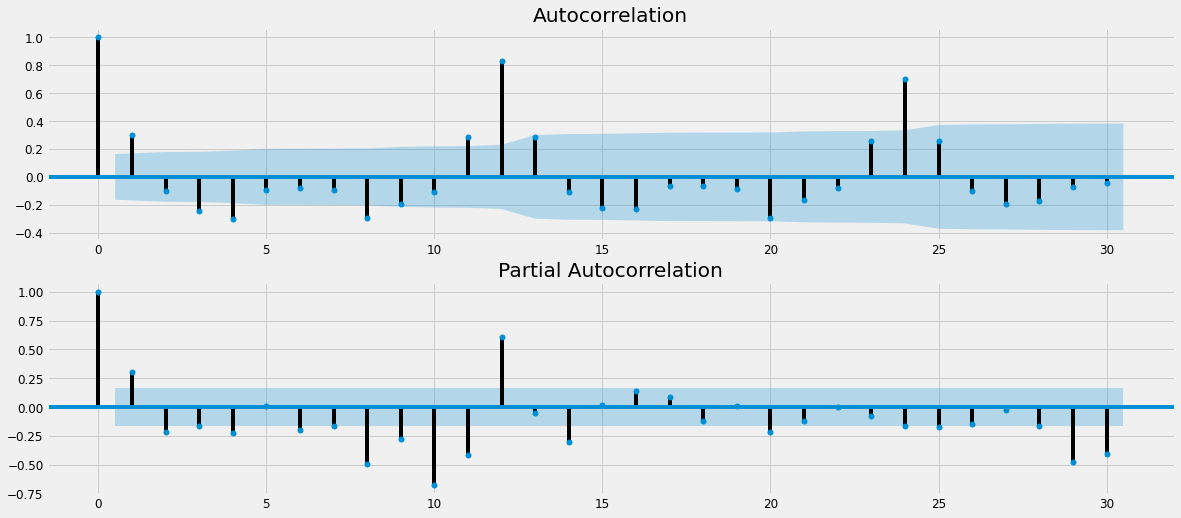

In [139]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpreting ACF plots


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

In [140]:
pd.plotting.register_matplotlib_converters()


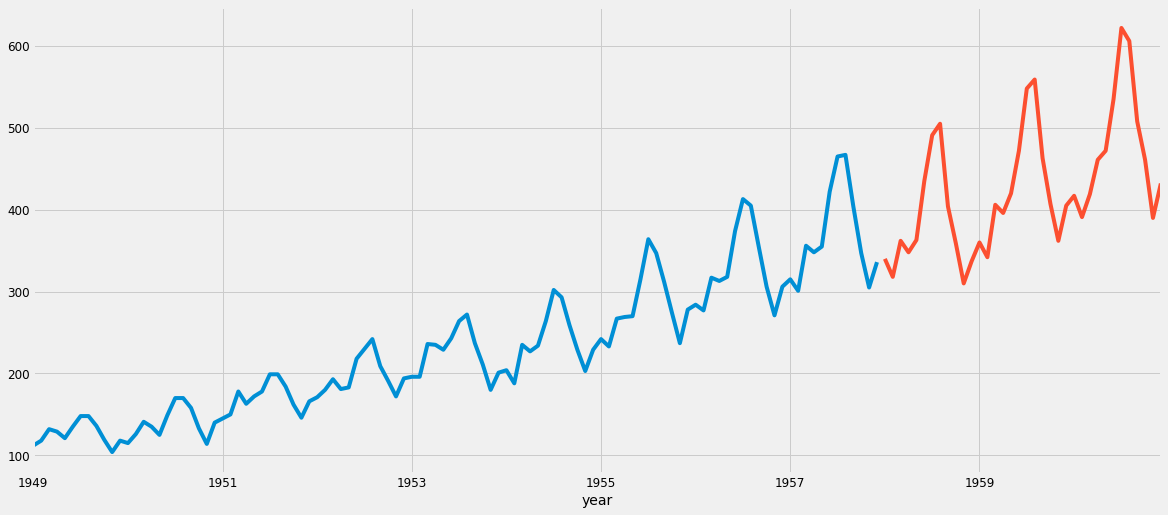

In [141]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [142]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [143]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Sun, 29 Nov 2020   AIC                            994.461
Time:                        05:19:31   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [144]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [145]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.6263796655409, MSE:187165.58438251278


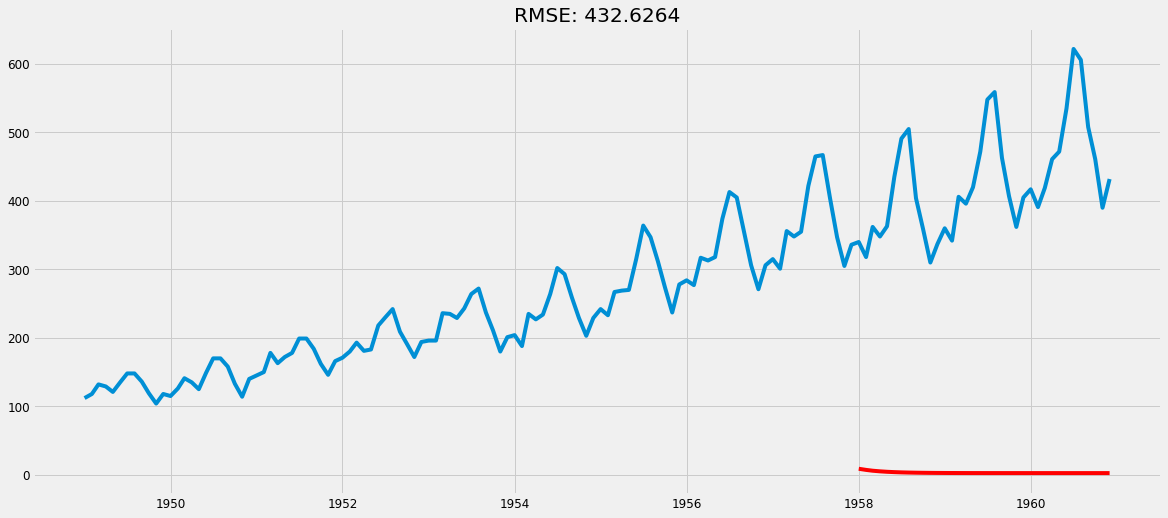

In [146]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

__Fitted or predicted values:__

In [147]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    8.743428
1958-02-01    7.109322
1958-03-01    5.898545
1958-04-01    5.001430
1958-05-01    4.336719
Freq: MS, dtype: float64


__Cumulative Sum to reverse differencing:__

In [148]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743428
1958-02-01    15.852750
1958-03-01    21.751295
1958-04-01    26.752724
1958-05-01    31.089444
Freq: MS, dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [149]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743428
1958-02-01    355.852750
1958-03-01    361.751295
1958-04-01    366.752724
1958-05-01    371.089444
dtype: float64

__Taking Exponent to reverse Log Transform:__

Text(0.5, 1.0, 'RMSE: 205.2935')

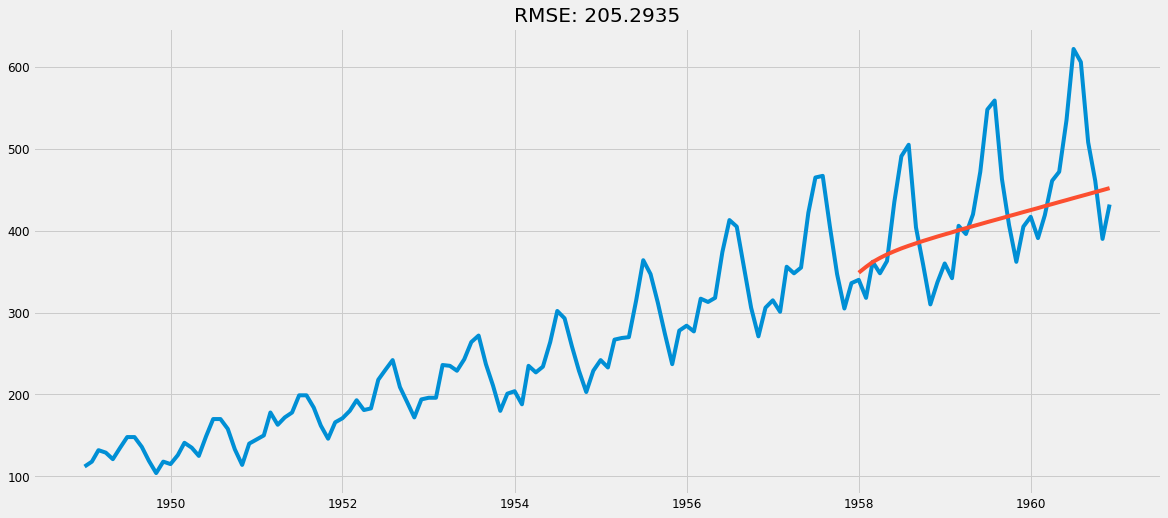

In [150]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [151]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.179865,52.106955,36.843691,5017.836219,0.023691,NaN,70.836687


### Auto ARIMA

In [155]:
# !pip install pyramid-arima

In [156]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=959.218, BIC=975.255, Fit time=0.336 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1002.826, BIC=1008.172, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=996.373, BIC=1004.392, Fit time=0.066 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=991.646, BIC=999.664, Fit time=0.080 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=971.486, BIC=984.850, Fit time=0.300 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=966.631, BIC=985.341, Fit time=0.419 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=969.040, BIC=982.405, Fit time=0.301 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=973.136, BIC=991.846, Fit time=0.435 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=988.670, BIC=999.361, Fit time=0.108 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

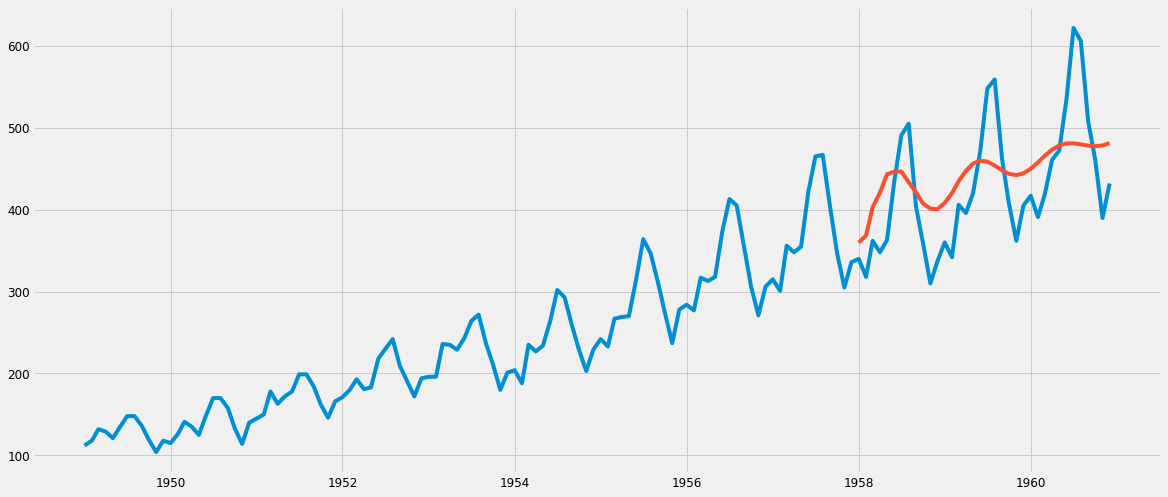

In [157]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [158]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.370489,52.899169,48.443947,3851.540919,0.019646,NaN,62.060784


## Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [159]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)

In [160]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [161]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 61.91042911491951, MSE:3832.9012331934737


Text(0.5, 1.0, 'RMSE: 61.9104')

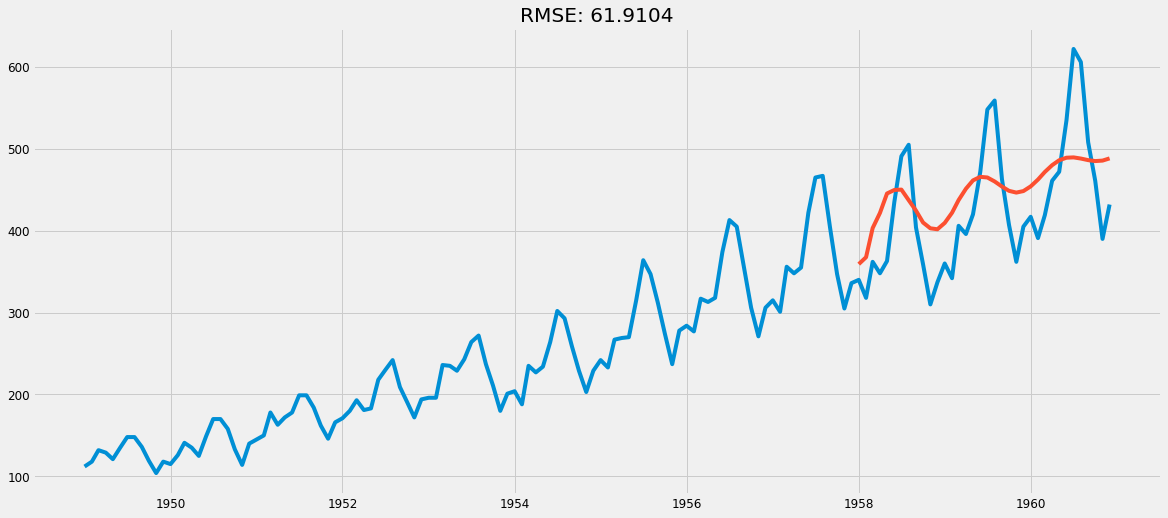

In [162]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [163]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.373535,53.654756,49.573229,3832.901233,0.019823,NaN,61.910429


### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [164]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 6); AIC=936.762, BIC=958.145, Fit time=0.902 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=1002.826, BIC=1008.172, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=997.166, BIC=1007.858, Fit time=0.134 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 6); AIC=993.576, BIC=1004.268, Fit time=0.176 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 6); AIC=956.753, BIC=975.463, Fit time=0.769 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 6); AIC=827.794, BIC=851.849, Fit time=1.585 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=816.226, BIC=837.608, Fit time=1.568 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=822.887, BIC=841.597, Fit time=1.292 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(2, 0, 0, 6); AIC=821.044, BIC=845.099, Fit time=1.332 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 0, 0,

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 6), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [165]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [166]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

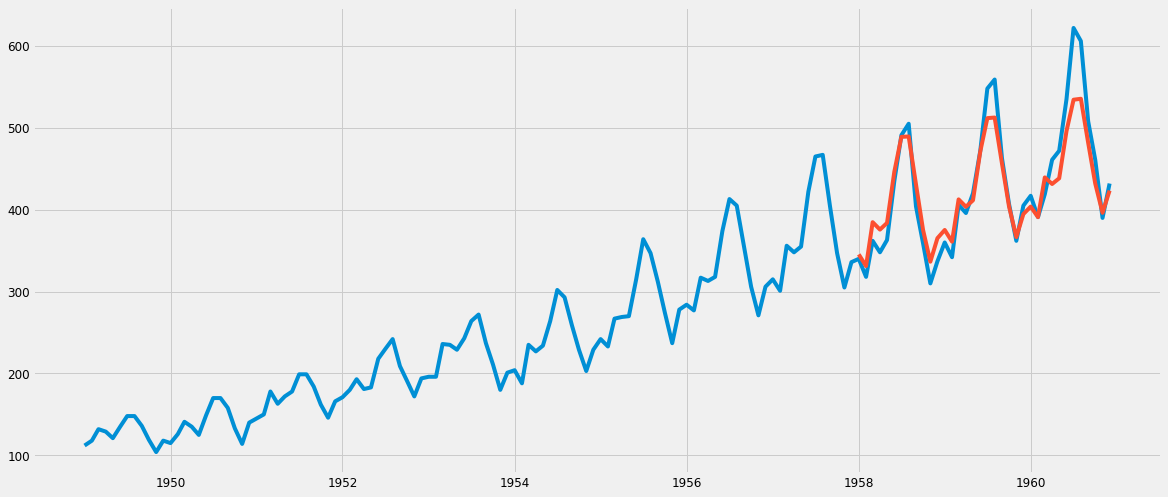

In [167]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [168]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.874684,20.706352,15.926626,766.72171,0.003304,NaN,27.68974


### Tuned SARIMA

In [169]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [170]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.708171707086
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.2677070067773
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445543
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.0958895418041
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602038
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006279
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113504
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.4912121257291
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.87806894588
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569616249
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884754574015
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396781682
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.5520247086818
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123024994
ARIMA(0, 1, 0)x(0, 1, 

In [171]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Sun, 29 Nov 2020   AIC                            682.471
Time:                                   05:21:22   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4552      0.082     -5.543      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.216      0.000      -1.122      -1.057
ma.S.L6        2.2736      0.600      3.791      0.000       1.098       3.449
sigma2        15.8260      7.949      1.991      0.046       0.247      31.405
===================================================================================
Ljung-Box (Q):                       45.44   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.26   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

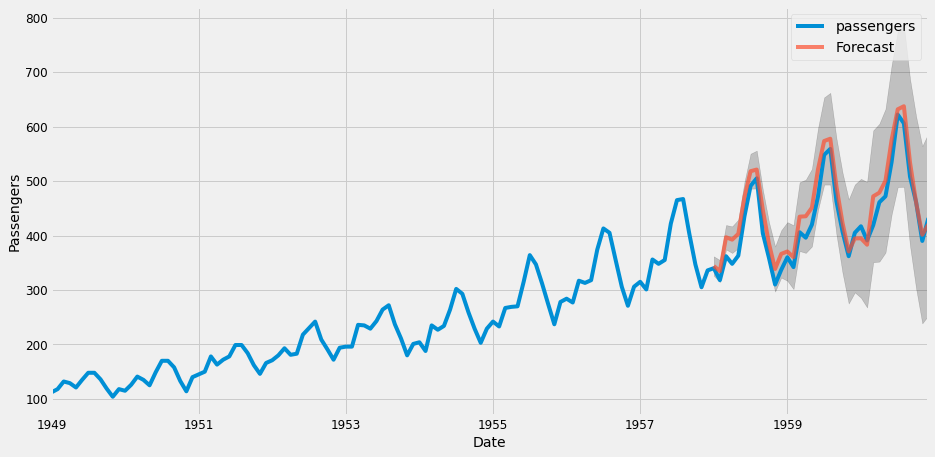

In [173]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

__Model diagnostics:__
- Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 
- If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. 
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
- This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

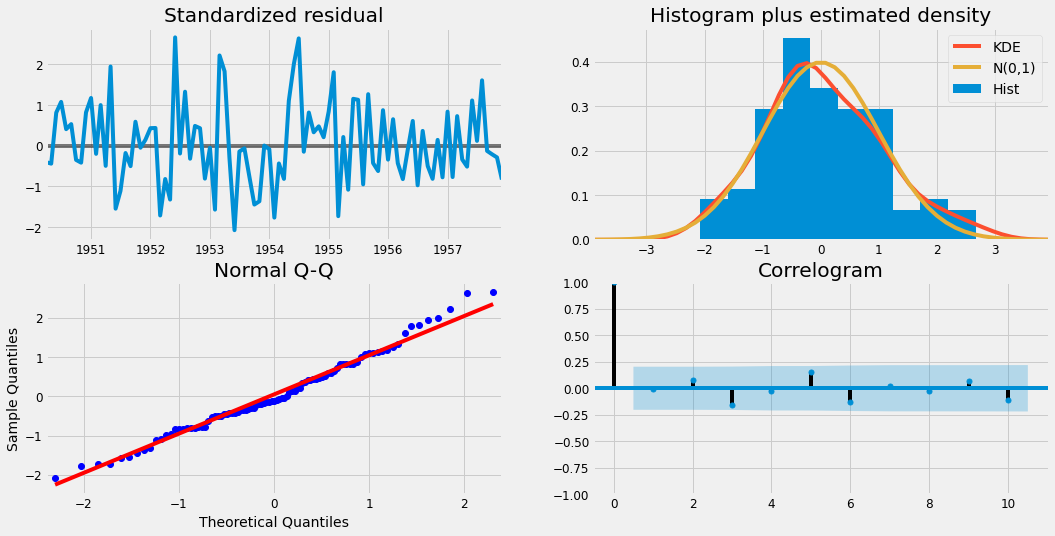

In [174]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [175]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.5


In [176]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.96


In [177]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.872268,24.733349,26.185187,781.501448,0.004216,5.932278,27.955347


## SARIMAX
- The implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.
- Exogenous variables are optional can be specified via the “exog” argument.
 - model = SARIMAX(data, exog=other_data, ...)
- Examples of exogenous variables: Population, holidays, number of airline companies, major events

In [178]:
df.head(),df.shape

(        year  passengers
 0 1949-01-01         112
 1 1949-02-01         118
 2 1949-03-01         132
 3 1949-04-01         129
 4 1949-05-01         121, (144, 2))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



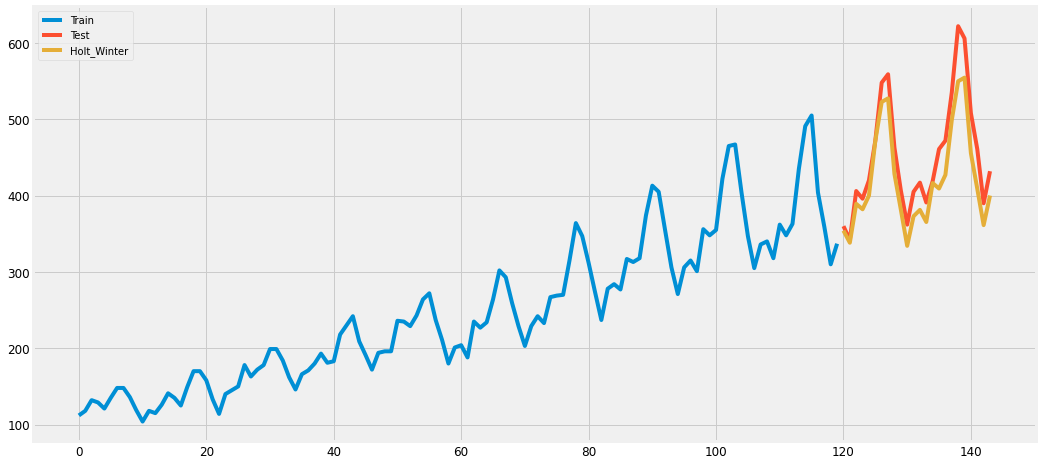

In [104]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
train = df.iloc[:120,:]
test = df.iloc[120:,:]

y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['passengers']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()  ## change seasonal period to 7
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['passengers'], label='Train')
plt.plot(test['passengers'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

## Prophet
- [Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune. 

[Prophet example notebooks](https://github.com/facebook/prophet/tree/master/notebooks)

__Trend parameters__

- growth: 'linear' or 'logistic' to specify a linear or logistic trend
- changepoints:	List of dates at which to include potential changepoints (automatic if not specified)
- n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included
- changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection
 

__Seasonality and Holiday Parameters__

- yearly_seasonality: Fit yearly seasonality
- weekly_seasonality: Fit weekly seasonality
- daily_seasonality: Fit daily seasonality
- holidays: Feed dataframe containing holiday name and date
- seasonality_prior_scale: Parameter for changing strength of seasonality model
- holiday_prior_scale: Parameter for changing strength of holiday model

Prophet requires the variable names in the time series to be:

- y – Target
- ds – Datetime

In [53]:
train.head()

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [54]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.passengers.values

In [55]:
train_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [56]:
from fbprophet import Prophet

#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
train_prophet.shape

(108, 2)

In [58]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS') 
future.tail(),future.shape

(            ds
 139 1960-08-01
 140 1960-09-01
 141 1960-10-01
 142 1960-11-01
 143 1960-12-01, (144, 1))

In [60]:
#forecast.columns

In [61]:

# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,618.345422,600.261347,634.981956
140,1960-09-01,535.809493,518.116865,551.002593
141,1960-10-01,467.367447,450.904018,480.946489
142,1960-11-01,414.474781,398.959752,428.260787
143,1960-12-01,460.984813,446.191360,475.743248


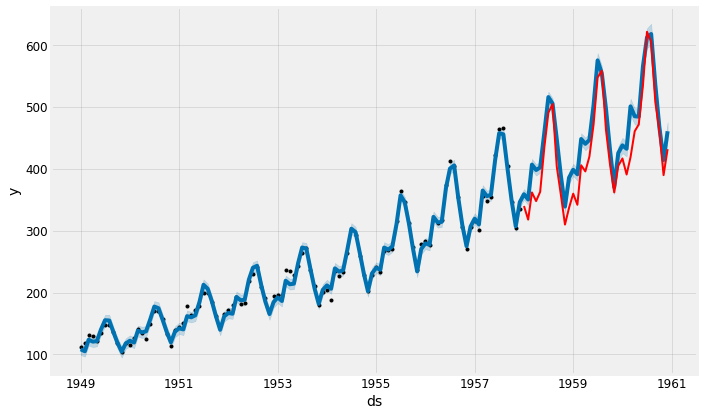

In [62]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

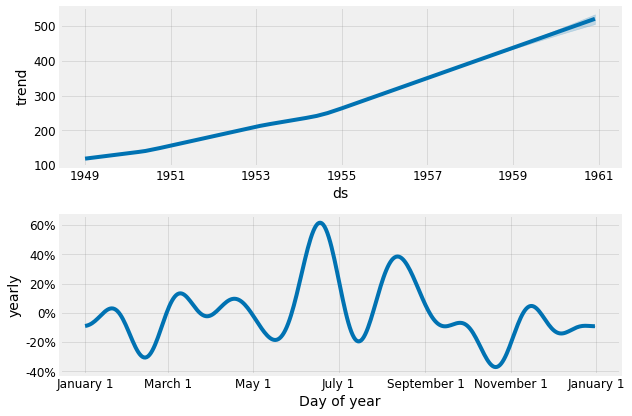

In [63]:
model.plot_components(forecast);

In [64]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.passengers.values

In [65]:
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [66]:
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])

NameError: ignored

In [ ]:
#### trying phrpophet on LNT

In [ ]:
trainf=pd.read_csv("datafiles/train_fwYjLYX.csv",parse_dates=['application_date'], index_col='application_date')
testf=pd.read_csv("datafiles/test_1eLl9Yf.csv",parse_dates=['application_date'], index_col='application_date')
samplesub=pd.read_csv("datafiles/sample_submission_IIzFVsf.csv")

In [ ]:
trainf['Timestamp'] = pd.to_datetime(trainf.index,format='%Y-%m-%d') 
testf['Timestamp'] = pd.to_datetime(testf.index,format='%Y-%m-%d') 
samplesub['Timestamp'] = pd.to_datetime(samplesub.index,format='%Y-%m-%d') 

In [ ]:
trainf.index = trainf['Timestamp']
testf.index = testf['Timestamp']
samplesub.index = samplesub['Timestamp']


del trainf['Timestamp']
del testf['Timestamp']
del samplesub['Timestamp']

In [ ]:
## seperating two segments
#For business segment 1, historical data has been made available at branch ID level
#For business segment 2, historical data has been made available at State level.
 
segment1=trainf[trainf['segment']==1]
print(segment1.shape)
segment2=trainf[trainf['segment']==2]
print(segment2.shape)

segment2=segment2.drop(['branch_id','zone'],axis = 1)

(66898, 5)
(13504, 5)


In [ ]:
#### taking Kerala to start
s = "KERALA"
serieskerala=segment2[segment2['state']==s]


In [ ]:
#divide into train and validation set
train = serieskerala[:int(0.75*(len(serieskerala)))]
valid = serieskerala[int(0.75*(len(serieskerala))):]

In [ ]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.case_count.values


#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( weekly_seasonality=True, seasonality_mode = 'multiplicative')
model.add_country_holidays(country_name='US')

model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
train_prophet.shape

(633, 2)

In [ ]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 90, freq = 'MS') 
future.shape

(723, 1)

In [ ]:

# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2017-04-01,621.801135,-365.406435,1595.971704
1,2017-04-02,364.925674,-597.268174,1303.198687
2,2017-04-03,688.743166,-142.134624,1657.009961
3,2017-04-04,765.114551,-217.698797,1765.024458
4,2017-04-05,793.145574,-226.232348,1745.473274


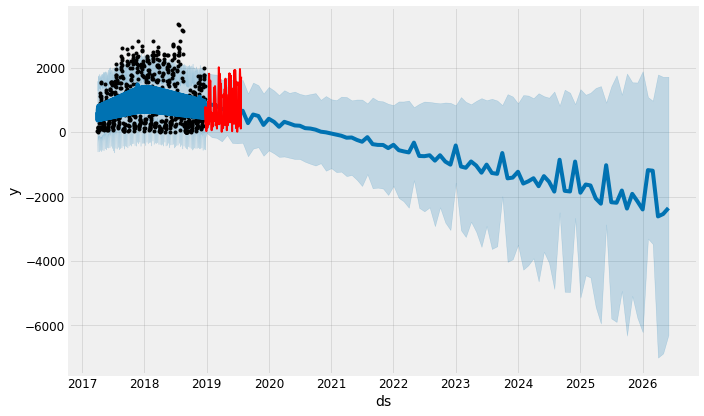

In [ ]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid.case_count, label='Valid', color = 'red', linewidth = 2)

plt.show()

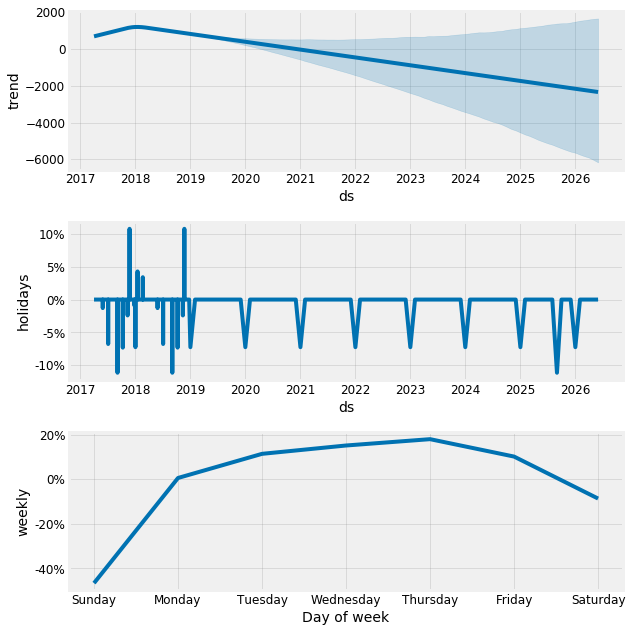

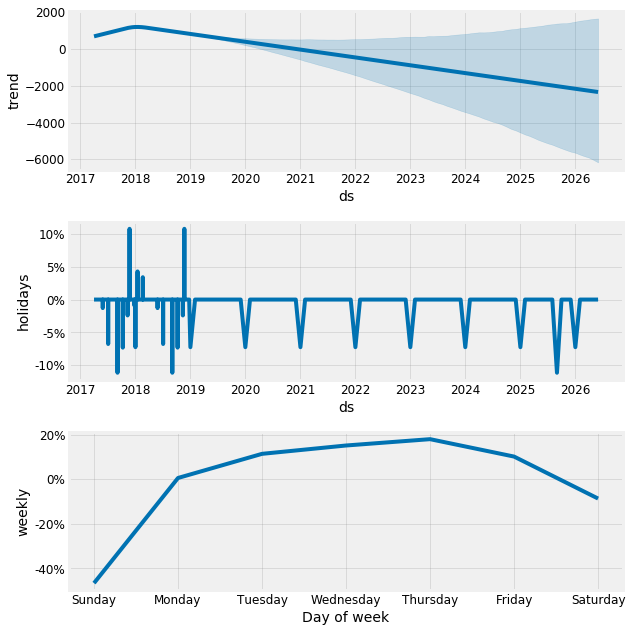

In [ ]:
model.plot_components(forecast)

**Pyflux**

In [180]:
# !pip install pyflux


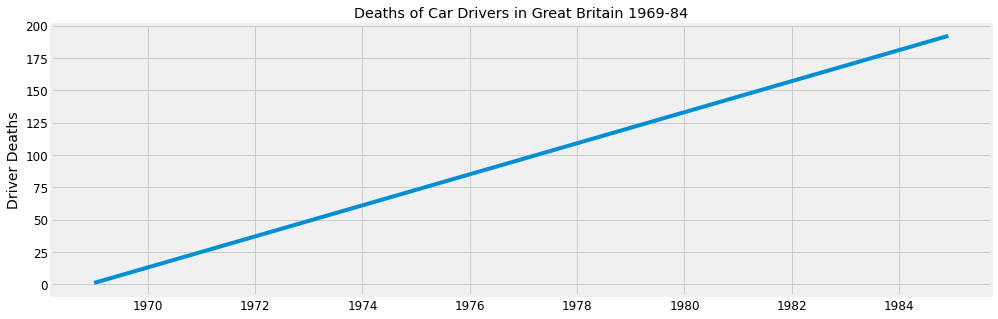

In [181]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv")
data.columns = ['drivers','time','value']
data.index = data['time'];
data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;
plt.figure(figsize=(15,5));
plt.plot(data.index,data['drivers']);
plt.ylabel('Driver Deaths');
plt.title('Deaths of Car Drivers in Great Britain 1969-84');
plt.plot();

In [182]:
model = pf.ARIMAX(data=data, formula='drivers~1+seat_belt+oil_crisis',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: drivers                             Method: MLE                                       
Start Date: 1969.08333333333                            Log Likelihood: 2150.2364                         
End Date: 1984.91666666667                              AIC: -4288.4728                                   
Number of observations: 191                             BIC: -4268.9591                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.0        0.0        16521402 0.0      (1.0 | 1.0)              
MA(1)                                

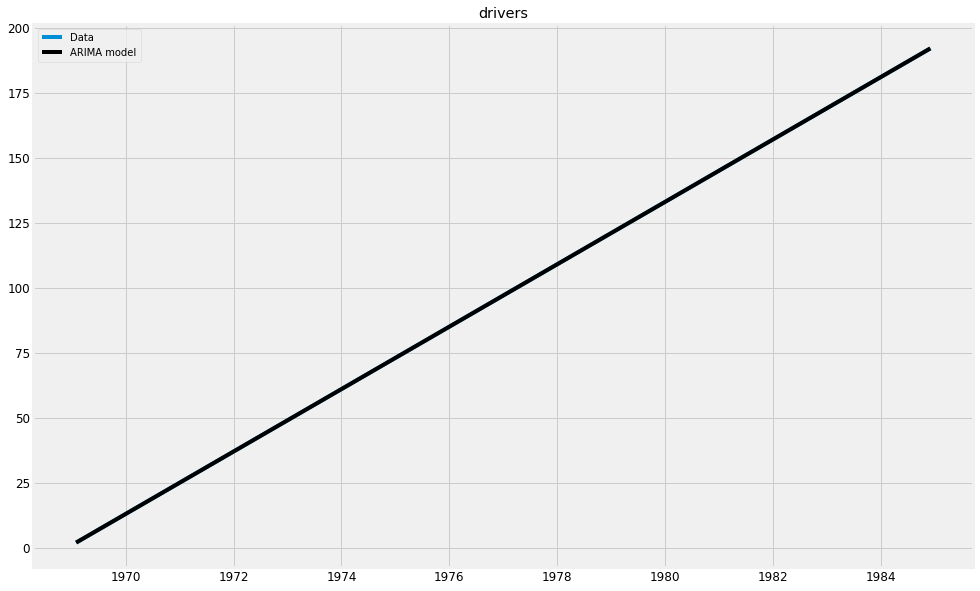

In [183]:
model.plot_fit(figsize=(15,10))


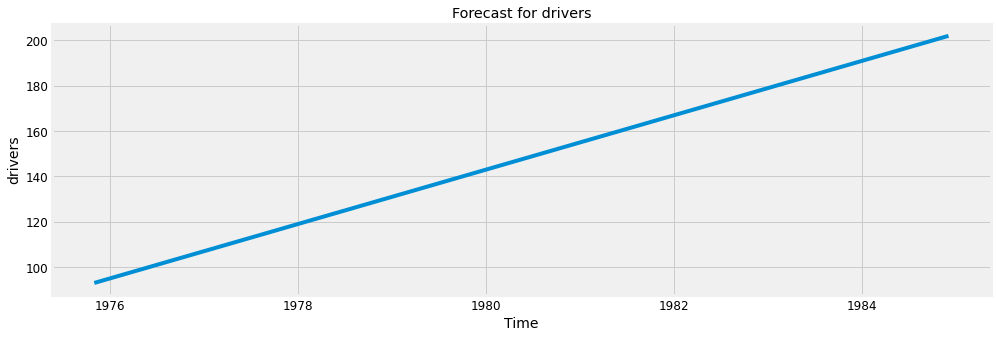

In [185]:
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))


In [188]:
data

,drivers,time,value,seat_belt,oil_crisis
time,,,,,
1969.000000,1,1969.000000,1687,0.0,0.0
1969.083333,2,1969.083333,1508,0.0,0.0
1969.166667,3,1969.166667,1507,0.0,0.0
1969.250000,4,1969.250000,1385,0.0,0.0
1969.333333,5,1969.333333,1632,0.0,0.0
...,...,...,...,...,...
1984.583333,188,1984.583333,1284,1.0,1.0
1984.666667,189,1984.666667,1444,1.0,1.0
1984.750000,190,1984.750000,1575,1.0,1.0


In [190]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
m1 = SARIMAX(endog=data['drivers'],exog=data['seat_belt'])

In [285]:
g = 1
while g == 1:
  r=3

KeyboardInterrupt: ignored

SARIMAX

In [197]:
#Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os
%matplotlib inline

In [201]:
dataset= pd.read_csv("datafiles/aapl.csv")


In [202]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset.head(2)

,Date,Open,High,Low,Close,Volume,Name,Mean
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL,10.500
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL,10.745


In [203]:
# preparing the dataset by shoifting open , close, Low, High  by 1
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,Open,High,Low,Close,Volume,Name,Mean,Actual
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL,10.500,10.745
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL,10.745,10.620
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL,10.620,10.805


In [204]:
dataset_for_prediction=dataset_for_prediction.dropna()

In [205]:
dataset_for_prediction[2629:2640]

,Date,Open,High,Low,Close,Volume,Name,Mean,Actual
2629,2016-06-15,97.82,98.41,97.03,97.14,29445227,AAPL,97.720,96.910
2630,2016-06-16,96.45,97.75,96.07,97.55,31326815,AAPL,96.910,95.975
2631,2016-06-17,96.62,96.65,95.30,95.33,61008219,AAPL,95.975,95.800
2632,2016-06-20,96.00,96.57,95.03,95.10,34411901,AAPL,95.800,95.515
2633,2016-06-21,94.94,96.35,94.68,95.91,35546358,AAPL,95.515,96.120
2634,2016-06-22,96.25,96.89,95.35,95.55,29219122,AAPL,96.120,95.770
2635,2016-06-23,95.94,96.29,95.25,96.10,32240187,AAPL,95.770,93.655
2636,2016-06-24,92.91,94.66,92.65,93.40,75311356,AAPL,93.655,92.275
2637,2016-06-27,93.00,93.05,91.50,92.04,46622188,AAPL,92.275,92.900
2638,2016-06-28,92.90,93.66,92.14,93.59,40444914,AAPL,92.900,94.090


In [206]:
#from pandas.tseries.offsets import BDay
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']
#dataset_test.index.freq='B'


Text(0.5, 1.0, ' Apple Stock Value')

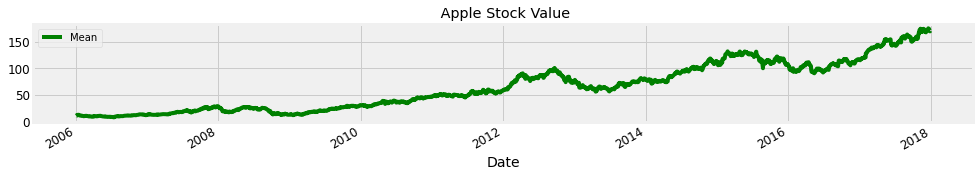

In [207]:

dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend([  'Mean'])
plt.title(" Apple Stock Value")

Text(0.5, 1.0, ' Apple  Stock Volume')

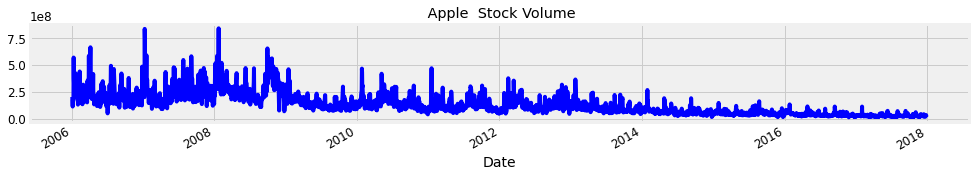

In [208]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title(" Apple  Stock Volume")

In [209]:
# normalizing input features
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [210]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [211]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Mean'}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_for_prediction.index
X.tail(2)

,Low,High,Open,Close,Volume,Mean
Date,,,,,,
2017-12-27,0.969289,0.962155,0.970129,0.965599,0.012049,0.965701
2017-12-28,0.973880,0.968463,0.975495,0.968436,0.006016,0.971156


In [212]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
Date,
2006-01-03,0.020040
2006-01-04,0.019299


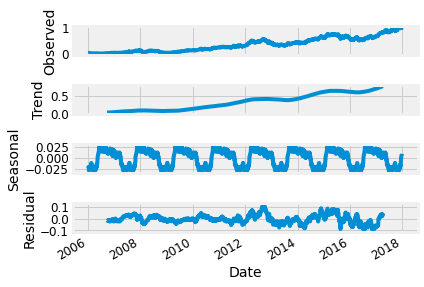

In [213]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [214]:
train_size=int(len(dataset) *0.80)
test_size = int(len(dataset)) - train_size
print(test_size)

604


In [215]:
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

In [216]:
y_test=y['Stock Price next day'][:train_size].dropna()

In [217]:

from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is  Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [218]:
test_adf(y_test, " Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for  Stock Price


In [219]:
test_adf(y_test.diff(), " Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is  Stationary
Data is Stationary  Stock Price


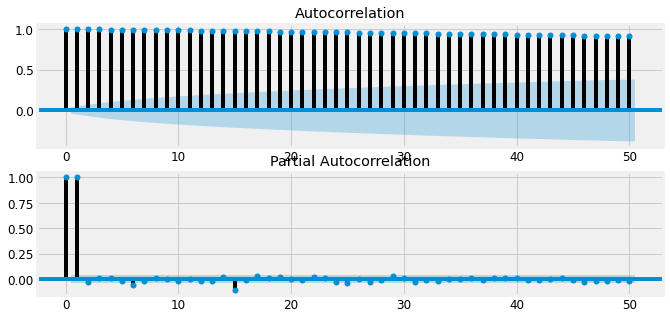

In [220]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()


In [222]:
from pyramid.arima import auto_arima
step_wise=auto_arima(train_y, 
                     exogenous= train_X,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-19214.864, BIC=-19156.973, Fit time=3.085 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-19200.041, BIC=-19153.729, Fit time=1.793 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-19208.867, BIC=-19156.766, Fit time=1.201 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-19323.593, BIC=-19271.492, Fit time=7.183 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-19207.529, BIC=-19149.639, Fit time=0.969 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-19298.526, BIC=-19234.847, Fit time=7.352 seconds
Total fit time: 21.596 seconds


In [223]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2415
Model:               SARIMAX(0, 1, 1)   Log Likelihood                9670.797
Date:                Sun, 29 Nov 2020   AIC                         -19323.593
Time:                        08:26:30   BIC                         -19271.492
Sample:                             0   HQIC                        -19304.645
                               - 2415                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.521e-05   3.97e-05      1.895      0.058   -2.57e-06       0.000
x1             0.0556      0.024      2.328      0.020       0.009       0.102
x2            -0.0083      0.036     -0.231      0.817      -0.079       0.062
x3            -0.2037      0.031     -6.673      0.000      -0.264      -0.144
x4             0.8463      0.031     27.411      0.000       0.786       0.907
x5             0.0023      0.002      1.322      0.186      -0.001       0.006
x6             0.0235      0.020      1.153      0.249      -0.016       0.063
ma.L1         -0.6031      0.040    -15.156      0.000      -0.681      -0.525
sigma2      1.935e-05    1.8e-07    107.488      0.000     1.9e-05    1.97e-05
===================================================================================
Ljung-Box (Q):                      106.66   Jarque-Bera (JB):             55927.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.75   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.09e+16. Standard errors may be unstable.
"""

In [224]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
           exog=train_X,
              order=(0,1,1),
              enforce_invertibility=False, enforce_stationarity=False)

In [225]:
results= model.fit()

In [226]:
step_wise=auto_arima(train_y, 
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-18736.909, BIC=-18713.753, Fit time=0.965 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-18646.268, BIC=-18634.690, Fit time=0.389 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-18726.823, BIC=-18709.456, Fit time=0.369 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-18737.529, BIC=-18720.162, Fit time=1.389 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-18738.029, BIC=-18714.872, Fit time=1.720 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-18735.717, BIC=-18700.983, Fit time=1.160 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-18736.842, BIC=-18707.897, Fit time=1.298 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-18738.221, BIC=-18709.276, Fit time=1.407 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 0, 1); AIC=-18736.006, BIC=-18695.482, Fit time=1.353 seconds
F

In [227]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2415
Model:               SARIMAX(0, 1, 3)   Log Likelihood                9374.111
Date:                Sun, 29 Nov 2020   AIC                         -18738.221
Time:                        08:27:12   BIC                         -18709.276
Sample:                             0   HQIC                        -18727.694
                               - 2415                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.213      0.027    2.97e-05       0.000
ma.L1          0.1978      0.013     15.143      0.000       0.172       0.223
ma.L2         -0.0373      0.014     -2.633      0.008      -0.065      -0.010
ma.L3         -0.0243      0.015     -1.634      0.102      -0.053       0.005
sigma2      2.476e-05   2.74e-07     90.468      0.000    2.42e-05    2.53e-05
===================================================================================
Ljung-Box (Q):                       71.38   Jarque-Bera (JB):             18651.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.56   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
steps

-1

In [229]:
model= SARIMAX(train_y, 
               exog=train_X,            
              order=(0,1,1),
              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
print(len(predictions))

603


In [230]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [231]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])


In [232]:
forecast_apple= pd.DataFrame(forecast_1)
forecast_apple.reset_index(drop=True, inplace=True)
forecast_apple.index=test_X.index
forecast_apple['Actual'] =scaler_output.iloc[train_size:, 0]
forecast_apple.rename(columns={0:'Forecast'}, inplace=True)

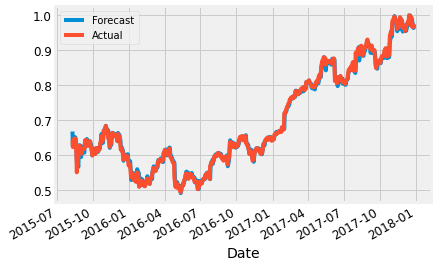

In [233]:
forecast_apple['Forecast'].plot(legend=True)
forecast_apple['Actual'].plot(legend=True)

In [234]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)



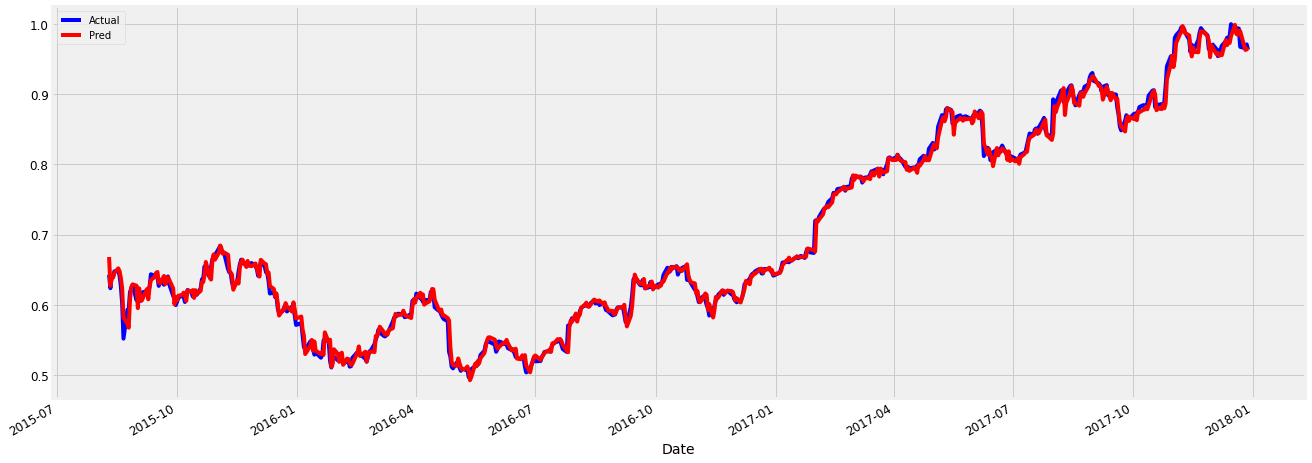

In [235]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))



In [236]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

0.008237881904561482

Inverse Scale

In [237]:
X.head(2)


,Low,High,Open,Close,Volume,Mean
Date,,,,,,
2006-01-03,0.018785,0.018392,0.017589,0.020333,0.228877,0.018587
2006-01-04,0.020693,0.019394,0.019914,0.020511,0.172820,0.020040


In [238]:
# invert predictions, scale values back to real index/price range.
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [240]:
act_1=pd.DataFrame(testActual)

In [251]:
act_1.head()

,0
0,115.755
1,112.525
2,115.470
3,115.160
4,116.575


In [268]:
rt= testActual.reshape(1,-1)

In [272]:
g = pd.DataFrame(sc_out.inverse_transform(act[['Stock Price next day']]))
g.columns = ['act1']
g['act2'] = rt[0]


In [273]:
g.head()

,act1,act2
0,115.755,115.755
1,112.525,112.525
2,115.470,115.470
3,115.160,115.160
4,116.575,116.575


In [274]:
#act_pred=pd.DataFrame()
act_pred= pd.DataFrame(testPredict)
act_pred.reset_index(drop=True, inplace=True)
act_pred.index=test_X.index
act_pred['Actual'] = rt[0] #act['Stock Price next day']
act_pred.rename(columns={0:'Pred'}, inplace=True)

In [275]:
act_pred.head()

,Pred,Actual
Date,,
2015-08-10,120.027369,115.755
2015-08-11,113.093546,112.525
2015-08-12,115.136503,115.470
2015-08-13,115.111191,115.160
2015-08-14,116.177376,116.575


In [276]:
predictions.head()

,Pred,Actual
Date,,
2015-08-10,0.667965,0.642635
2015-08-11,0.626855,0.623484
2015-08-12,0.638968,0.640945
2015-08-13,0.638818,0.639107
2015-08-14,0.645139,0.647497


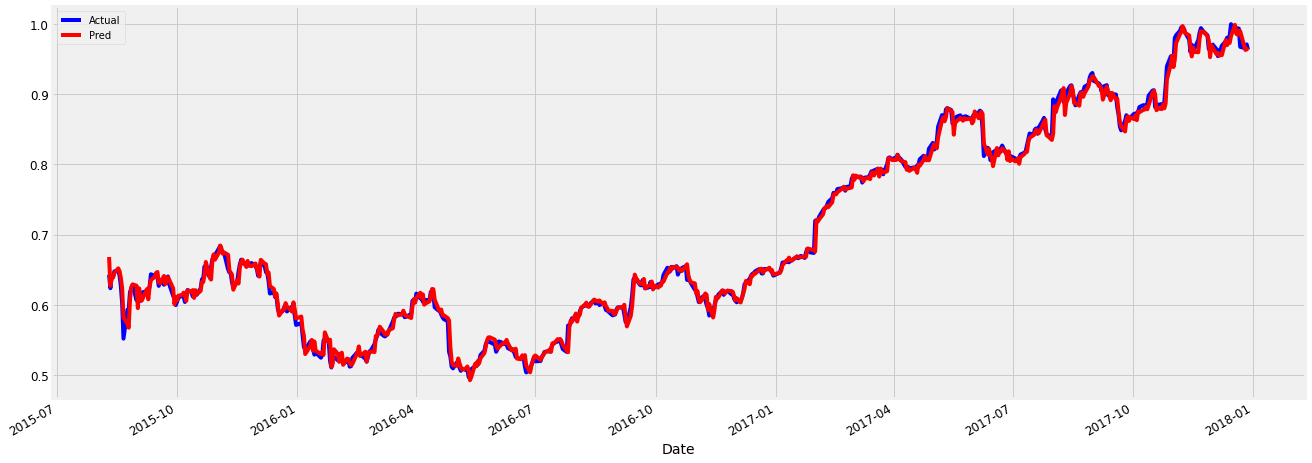

In [246]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

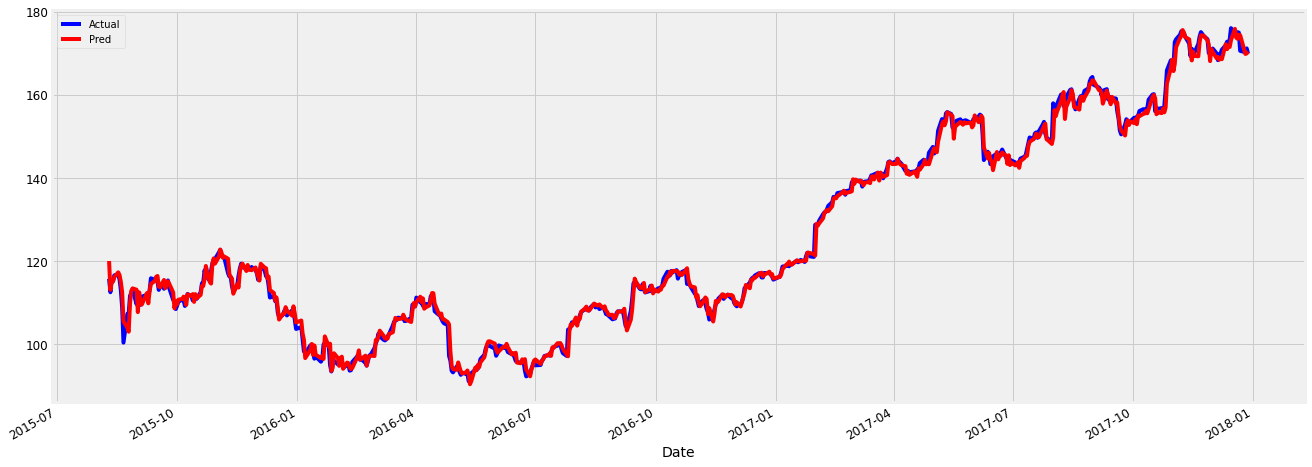

In [279]:
act_pred['Actual'].plot(figsize=(20,8), legend=True, color='blue')
act_pred['Pred'].plot(legend=True, color='red', figsize=(20,8))